<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Flatten, Reshape
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow import keras
from sklearn.model_selection import train_test_split

## Preparation of the training data

In [4]:
training_data = pd.read_csv('training_set_N80K_Nsim500.csv')
training_data = training_data.to_numpy()
X_data = training_data[:,:5]
y_data = training_data[:,5:]
X = X_data
target_y = np.log1p(y_data)

print(training_data.shape)
print('X shape:', X.shape)
print('Y shape:', target_y.shape)

(80000, 93)
X shape: (80000, 5)
Y shape: (80000, 88)


Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [5]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [6]:
#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([np.max(X_train[:,0]),  np.max(X_train[:,1]),  np.max(X_train[:,2]), np.max(X_train[:,3]), np.max(X_train[:,4])])
x_min = np.array([np.min(X_train[:,0]),  np.min(X_train[:,1]),  np.min(X_train[:,2]), np.min(X_train[:,3]), np.min(X_train[:,4])])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [7]:
#Let's check the range for each parameter:
print('x_max:', x_max)
print('x_min:', x_min)

x_max: [ 0.24999554 59.99967648 34.99998938  4.99990324 -0.10001961]
x_min: [ 0.03000144 10.0001457   5.00010427  1.00000906 -0.89998256]


In [8]:
#Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

Check that the values of the dataset have been well preprocessed :

In [9]:
print("Min X_train après normalisation:", x_train_transform.min())
print("Max X_train après normalisation:", x_train_transform.max())
print("Mean y_train_transform:", y_train_transform.mean())
print("Std y_train_transform:", y_train_transform.std())


Min X_train après normalisation: -1.0
Max X_train après normalisation: 1.0
Mean y_train_transform: 1.1702676854906591e-14
Std y_train_transform: 0.9999999999999951


Ok all good

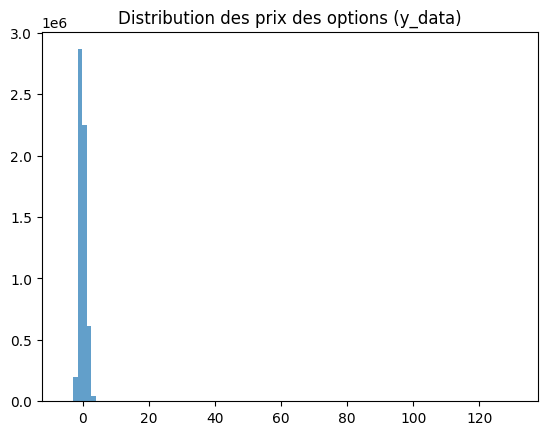

In [10]:
import matplotlib.pyplot as plt

plt.hist(y_train_transform.flatten(), bins=100, alpha=0.7, label='y_train_transform')
plt.title("Distribution des prix des options (y_data)")
plt.show()

## Building of the Neural Network

In [9]:
model_iv = keras.models.Sequential([
    keras.layers.Input(shape=(5,)),
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),
    keras.layers.Dense(30, activation="tanh"),

    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
])

model_iv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,558 (29.52 KB)

 Trainable params: 7,558 (29.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def error_function(y_true, y_pred):
    return tf.sqrt(tf.math.reduce_mean((y_pred - y_true) ** 2))

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)

model_iv.compile(optimizer=optimizer, loss=error_function)
train_hist = model_iv.fit(x_train_transform, y_train_transform, batch_size=16, epochs=200, validation_data=(x_test_transform, y_test_transform))

Epoch 1/200


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.9117 - val_loss: 0.6666
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.6328 - val_loss: 0.6204
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.6861 - val_loss: 0.6150
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6108 - val_loss: 0.5918
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.5949 - val_loss: 0.5797
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6454 - val_loss: 0.5721
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.5897 - val_loss: 0.5721
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.5775 - val_loss: 0.5588
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6463 - val_loss: 0.5516
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.5316 - val_loss: 0.5454
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6602 - val_loss: 0.5390
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6

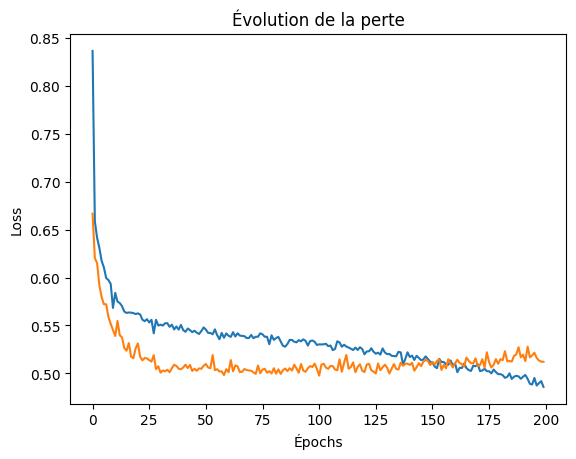

In [11]:
plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [12]:
# Save the model weights
model_iv.save_weights('2FBergomiNNWeights_test.weights.h5')

In [13]:
model_iv.load_weights('2FBergomiNNWeights_test.weights.h5')

In [14]:
test_loss = model_iv.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4996
Test Loss: 0.5209031701087952


### Avec Batch Normalization 

In [15]:
model_iv_2 = keras.models.Sequential([
    keras.layers.Input(shape=(5,)),

    Dense(30, activation=None), 
    BatchNormalization(),
    keras.layers.Activation("tanh"),

    Dense(30, activation=None), 
    BatchNormalization(), 
    keras.layers.Activation("tanh"),

    Dense(30, activation=None),  
    BatchNormalization(),
    keras.layers.Activation("tanh"),

    Dense(30, activation=None), 
    BatchNormalization(),
    keras.layers.Activation("tanh"),

    Dense(30, activation=None),  
    BatchNormalization(),
    keras.layers.Activation("tanh"),

    Dense(30, activation=None),
    BatchNormalization(),
    keras.layers.Activation("tanh"),

    Dense(y_train_transform.shape[1], activation="linear")
])

model_iv_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 30)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,278 (32.34 KB)

 Trainable params: 7,918 (30.93 KB)

 Non-trainable params: 360 (1.41 KB)

In [16]:
optimizer_2 = Adam(learning_rate=0.001)


model_iv_2.compile(optimizer=optimizer_2, loss=error_function)
train_hist_2 = model_iv_2.fit(x_train_transform, y_train_transform, batch_size=16, epochs=200, validation_data=(x_test_transform, y_test_transform))

Epoch 1/200


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.9154 - val_loss: 0.6926
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.7547 - val_loss: 0.6359
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.6399 - val_loss: 0.6059
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.6722 - val_loss: 0.5955
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.6525 - val_loss: 0.5754
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - loss: 0.6219 - val_loss: 0.5664
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 0.6354 - val_loss: 0.5713
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - loss: 0.6210 - val_loss: 0.5654
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - loss: 0.6072 - val_loss: 0.5664
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - loss: 0.7211 - val_loss: 0.5646
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - loss: 0.6102 - val_loss: 0.5643
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 221

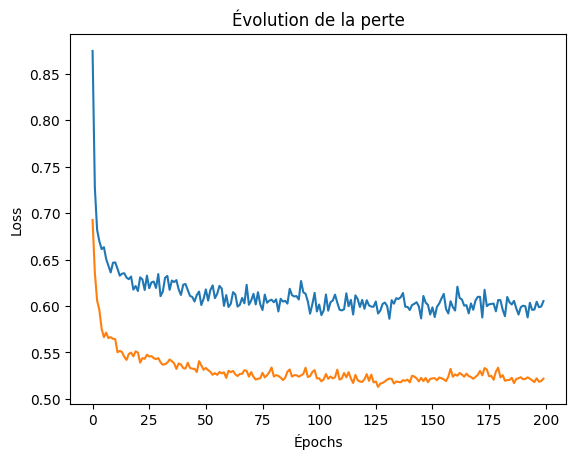

In [18]:
plt.plot(train_hist_2.history['loss'])
plt.plot(train_hist_2.history['val_loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [20]:
test_loss_2 = model_iv_2.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss_2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5153
Test Loss: 0.5280715227127075


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### CNN 

In [11]:
num_strikes = 11 
num_maturities = 8
output_shape = (num_strikes, num_maturities, 1)

model_cnn = keras.models.Sequential([
    #on transforme bergomi en image
    Dense(128, activation="elu", input_shape=(5,)), 
    Dense(num_strikes * num_maturities, activation="elu"),
    Reshape(output_shape),  
    
    Conv2D(32, kernel_size=(3,3), activation="elu", padding="same"),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3,3), activation="elu", padding="same"),
    BatchNormalization(),
    
    Conv2D(1, kernel_size=(3,3), activation="linear", padding="same"),  # 1 seule sortie par pixel
    Flatten()  # Remettre sous forme de vecteur (88 prix d'options)
])

model_cnn.compile(optimizer="adam", loss="mse")

model_cnn.summary()


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 88)             │        11,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 11, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 8, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 8, 1)       │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 88)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,233 (86.85 KB)

 Trainable params: 22,105 (86.35 KB)

 Non-trainable params: 128 (512.00 B)

In [12]:
train_hist_cnn = model_cnn.fit(x_train_transform, y_train_transform, batch_size=16, epochs=100, validation_data=(x_test_transform, y_test_transform))


Epoch 1/100


c:\Users\diane\anaconda3\envs\envy\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4250/4250 ━━━━━━━━━━━━━━━━━━━━ 325s 77ms/step - loss: 0.4001 - val_loss: 0.3355
Epoch 2/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 609s 143ms/step - loss: 0.3321 - val_loss: 0.3358
Epoch 3/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 552s 130ms/step - loss: 0.3336 - val_loss: 0.3299
Epoch 4/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 302s 71ms/step - loss: 0.3192 - val_loss: 0.3284
Epoch 5/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 303s 71ms/step - loss: 0.3376 - val_loss: 0.3284
Epoch 6/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 304s 72ms/step - loss: 0.3133 - val_loss: 0.3256
Epoch 7/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 303s 71ms/step - loss: 0.3293 - val_loss: 0.3249
Epoch 8/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 305s 72ms/step - loss: 0.3218 - val_loss: 0.3244
Epoch 9/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 305s 72ms/step - loss: 0.3390 - val_loss: 0.3236
Epoch 10/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 305s 72ms/step - loss: 0.3901 - val_loss: 0.3216
Epoch 11/100
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 306s 72ms/step - loss: 0.3620 - val_loss: 0.3

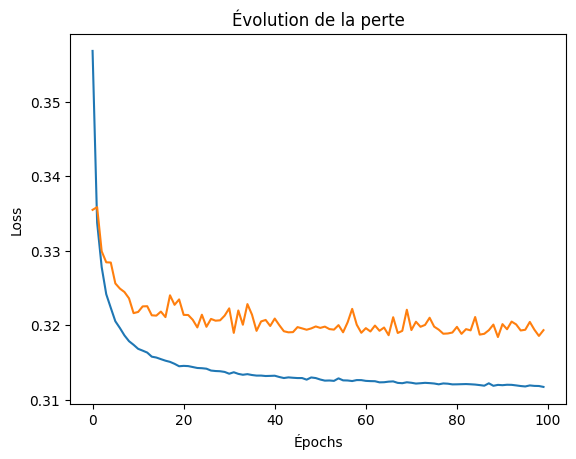

In [13]:
plt.plot(train_hist_cnn.history['loss'])
plt.plot(train_hist_cnn.history['val_loss'])
plt.title("Évolution de la perte")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.show()

In [14]:
test_loss_cnn = model_cnn.evaluate(x_test_transform, y_test_transform)
print(f"Test Loss: {test_loss_cnn}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3436
Test Loss: 0.31932610273361206


In [15]:
model_cnn.save_weights('2FBergomiNNWeights_test_cnn_batch16.weights.h5')

## Final predictions

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

In [ ]:
xi = 0.06
kappa = 41.6
eta_1 = 18.2428
eta_2 = 3.43
rho = -0.7

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_iv.predict(X_input_norm)

y_pred = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_1 = np.exp(y_pred)-1

print("Predicted option prices for parameter 1:", y_pred_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prix des options prédits : [[4.81785482e+01 3.85773392e+01 2.90010445e+01 1.94808591e+01
  1.01243697e+01 1.78224806e+00 4.27089254e-02 1.26625063e-02
  7.30881375e-03 4.47062485e-03 2.81739061e-03 4.84247151e+01
  3.88502346e+01 2.93385414e+01 1.99486862e+01 1.08578767e+01
  2.95448546e+00 2.35105041e-01 6.20487406e-02 2.71778624e-02
  1.78404530e-02 1.58773383e-02 4.88462194e+01 3.92813692e+01
  2.98214406e+01 2.05691141e+01 1.17552812e+01 4.21801840e+00
  6.66960925e-01 1.62992024e-01 6.49185605e-02 2.69260747e-02
  1.06509211e-02 4.92116171e+01 3.96167602e+01 3.02003780e+01
  2.10984894e+01 1.25471861e+01 5.28075107e+00 1.20104512e+00
  3.13823586e-01 1.17922884e-01 5.46527494e-02 2.21194561e-02
  4.96839321e+01 4.01180086e+01 3.07665255e+01 2.17613154e+01
  1.33646175e+01 6.26247837e+00 1.80443374e+00 5.48229113e-01
  2.14647486e-01 1.06378470e-01 5.86271397e-02 5.00485609e+01
  4.05039071e+01 3.12230600e+01 2.23272355e+01 1.40849031e+01
  7.1

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

In [ ]:
xi = 0.1
kappa = 15.6
eta_1 = 5.5857
eta_2 = 2.2867
rho = -0.4

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_iv.predict(X_input_norm)

y_pred = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_2 = np.exp(y_pred)-1

print("Predicted option prices for parameter 2:", y_pred_2)

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

In [ ]:
xi = 0.2
kappa = 54.6
eta_1 = 31.3496
eta_2 = 4.5733
rho = -0.8

X_input = np.array([[xi, kappa, eta_1, eta_2, rho]])
X_input_norm = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)

y_pred_norm = model_iv.predict(X_input_norm)

y_pred = output_norm_transform_inv(y_pred_norm, y_mean, y_std)
y_pred_3 = np.exp(y_pred)-1

print("Predicted option prices for parameter 3:", y_pred_3)

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018